In [1]:
import numpy as np
from moviepy import VideoFileClip, concatenate_videoclips
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import logging
from tqdm import tqdm  # For progress bars

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [3]:

def calculate_rms(audio_array, frame_size):
    """Calculate RMS energy for audio frames."""
    # Convert to mono if stereo
    if len(audio_array.shape) > 1:
        audio_array = np.mean(audio_array, axis=1)
    
    rms_energy = []
    for i in range(0, len(audio_array), frame_size):
        frame = audio_array[i:i + frame_size]
        rms = np.sqrt(np.mean(np.square(frame)))
        rms_energy.append(rms)
    
    return np.array(rms_energy)


In [4]:

def visualize_silent_segments(audio_array, fps, silence_threshold=-40, min_silence_len=1, figsize=(12, 6)):
    """Visualize audio segments with improved accuracy."""
    # Convert to mono if stereo
    if len(audio_array.shape) > 1:
        audio_array = np.mean(audio_array, axis=1)
    
    frame_size = int(fps * min_silence_len)
    frame_duration = frame_size / fps
    frames = list(range(0, len(audio_array), frame_size))
    
    rms_energy = calculate_rms(audio_array, frame_size)
    rms_db = 20 * np.log10(rms_energy + 1e-6)
    
    silent_frames = np.where(rms_db <= silence_threshold)[0]
    non_silent_frames = np.where(rms_db > silence_threshold)[0]
    
    time = np.arange(len(audio_array)) / fps
    frame_times = np.array(frames) / fps
    
    plt.figure(figsize=figsize)
    
    # Plot audio waveform
    plt.subplot(3, 1, 1)
    plt.plot(time, audio_array, color='blue', alpha=0.5)
    plt.title('Audio Waveform')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    # Plot RMS energy
    plt.subplot(3, 1, 2)
    plt.plot(frame_times, rms_db, color='green')
    plt.axhline(y=silence_threshold, color='red', linestyle='--', label=f'Threshold ({silence_threshold} dB)')
    plt.title('RMS Energy')
    plt.ylabel('dB')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot segments
    plt.subplot(3, 1, 3)
    ax = plt.gca()
    
    # Function to add rectangles
    def add_segments(frames, color, alpha):
        for frame in frames:
            start = frame * frame_duration
            rect = Rectangle((start, 0), frame_duration, 1, color=color, alpha=alpha)
            ax.add_patch(rect)
    
    add_segments(silent_frames, 'red', 0.5)
    add_segments(non_silent_frames, 'green', 0.5)
    
    plt.title('Silent (Red) vs Non-Silent (Green) Segments')
    plt.xlabel('Time (seconds)')
    plt.xlim(0, len(audio_array)/fps)
    plt.ylim(0, 1)
    plt.yticks([])
    plt.tight_layout()
    plt.show()
    
    silent_segments = [(f*frame_duration, (f+1)*frame_duration) for f in silent_frames]
    non_silent_segments = [(f*frame_duration, (f+1)*frame_duration) for f in non_silent_frames]
    
    total_duration = len(audio_array) / fps
    silent_duration = sum(e-s for s, e in silent_segments)
    
    logging.info(f"Found {len(silent_segments)} silent and {len(non_silent_segments)} non-silent segments")
    logging.info(f"Total duration: {total_duration:.2f}s, Silent: {silent_duration:.2f}s "
                 f"({silent_duration/total_duration*100:.1f}%)")
    
    return silent_segments, non_silent_segments


In [5]:
def detect_non_silent_segments(audio_array, fps, silence_threshold=-40, min_silence_len=1):
    """Detect non-silent segments with improved frame handling."""
    frame_size = int(fps * min_silence_len)
    rms_energy = calculate_rms(audio_array, frame_size)
    rms_db = 20 * np.log10(rms_energy + 1e-6)
    
    non_silent_frames = np.where(rms_db > silence_threshold)[0]
    segments = []
    
    if non_silent_frames.size == 0:
        return segments
    
    start = non_silent_frames[0]
    for i in range(1, len(non_silent_frames)):
        if non_silent_frames[i] - non_silent_frames[i-1] > 1:
            end = non_silent_frames[i-1]
            segments.append((start, end))
            start = non_silent_frames[i]
    segments.append((start, non_silent_frames[-1]))
    
    frame_duration = frame_size / fps
    return [(s*frame_duration, (e+1)*frame_duration) for s, e in segments]



In [6]:
def remove_silent_parts(video_path, output_path, silence_threshold=-40, min_silence_len=1, **kwargs):
    """Remove silent parts from video with improved error handling and progress tracking."""
    video = None
    final_clip = None
    try:
        logging.info("Loading video...")
        video = VideoFileClip(video_path)
        audio = video.audio
        
        if audio is None:
            raise ValueError("No audio track found in video")
        
        audio_fps = audio.fps
        audio_array = audio.to_soundarray(fps=audio_fps)
        
        logging.info("Detecting non-silent segments...")
        non_silent = detect_non_silent_segments(
            audio_array, audio_fps, silence_threshold, min_silence_len
        )

        visualize_silent_segments(audio_array, audio_fps, silence_threshold, min_silence_len
        )
        
        if not non_silent:
            logging.warning("No non-silent segments found")
            return
        
        logging.info(f"Extracting {len(non_silent)} segments...")
        subclips = []
        for start, end in tqdm(non_silent, desc="Processing segments"):
            subclips.append(video.subclipped(
                max(0, start),
                min(video.duration, end)
            ))
        
        logging.info("Creating final clip...")
        final_clip = concatenate_videoclips(subclips) if subclips else video
        
        # Export the final video without verbose/logger parameters
        logging.info(f"Exporting to {output_path}...")
        final_clip.write_videofile(
            output_path,
            codec="libx264",  # Default codec for MP4
            audio_codec="aac",
            **kwargs  # Pass additional parameters if needed
        )
        
    except Exception as e:
        logging.error(f"Processing failed: {str(e)}")
        raise
    finally:
        if video:
            video.close()
        if final_clip:
            final_clip.close()

2025-04-01 17:15:39,970 - INFO - Loading video...


{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'mp41isom', 'creation_time': '2025-04-01T08:53:29.000000Z'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1920, 1080], 'bitrate': 11947, 'fps': 19.84, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-04-01T08:53:29.000000Z', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'AVC Coding'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 48000, 'bitrate': 192, 'metadata': {'Metadata': '', 'creation_time': '2025-04-01T08:53:29.000000Z', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 9.08, 'bitrate': 12144, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h26

2025-04-01 17:15:40,545 - INFO - Detecting non-silent segments...


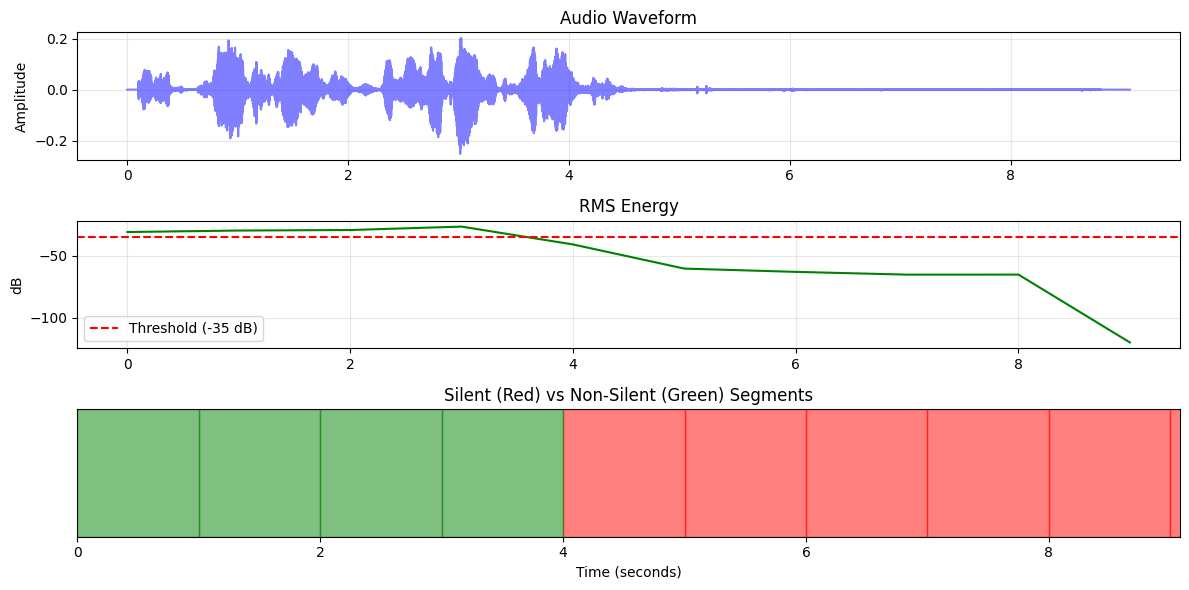

2025-04-01 17:15:40,750 - INFO - Found 6 silent and 4 non-silent segments
2025-04-01 17:15:40,755 - INFO - Total duration: 9.08s, Silent: 6.00s (66.1%)
2025-04-01 17:15:40,756 - INFO - Extracting 1 segments...
Processing segments: 100%|██████████| 1/1 [00:00<00:00, 5890.88it/s]
2025-04-01 17:15:40,761 - INFO - Creating final clip...
2025-04-01 17:15:40,761 - INFO - Exporting to test_output.mp4...


MoviePy - Building video test_output.mp4.
MoviePy - Writing audio in test_outputTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video test_output.mp4



MoviePy - Done !
MoviePy - video ready test_output.mp4


In [7]:
# Example usage
remove_silent_parts(
    "test.mp4", 
    "test_output.mp4", 
    silence_threshold=-35,
    min_silence_len=1
    )
